<a href="https://colab.research.google.com/github/dzakywd/talent-matching-intelligence-system/blob/main/talentmatch_01_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import pandas as pd

employees = pd.read_csv('employees_clean.csv')
psych = pd.read_csv('psych_clean.csv')
papi = pd.read_csv('papi_clean.csv')
strengths = pd.read_csv('strengths_clean.csv')
performance = pd.read_csv('performance_clean.csv')
competencies = pd.read_csv('competencies_clean.csv')

In [16]:
# One-Hot Encoding psych (DISC & MBTI)
disc_ohe = pd.get_dummies(psych['disc'], prefix='disc', dtype=int)
mbti_ohe = pd.get_dummies(psych['mbti'], prefix='mbti', dtype=int)
psych = psych.drop(columns=['disc', 'mbti'])
psych_encoded = pd.concat([psych, mbti_ohe, disc_ohe], axis=1)

# Pivot PAPI
papi_pivot = papi.pivot_table(
    index="employee_id",
    columns="scale_code",
    values="score",
    aggfunc="mean"
).reset_index()

papi_pivot.columns = [
    "employee_id" if c == "employee_id" else f"{c}"
    for c in papi_pivot.columns
]

# Pivot strength + weighted score
max_rank = strengths['rank'].max()
strengths['weight'] = max_rank + 1 - strengths['rank']  # Rank1=14, Rank2=13, etc
all_strengths = strengths['theme'].unique()
strengths_pivot = pd.DataFrame(0, index=strengths['employee_id'].unique(), columns=all_strengths)

for idx, row in strengths.iterrows():
    strengths_pivot.loc[row['employee_id'], row['theme']] += row['weight']

strengths_pivot = strengths_pivot.reset_index().rename(columns={'index': 'employee_id'})
strengths_pivot = strengths_pivot.drop(columns=[col for col in strengths_pivot.columns if pd.isna(col)])
strengths_pivot = strengths_pivot.rename(
    columns={col: f"str_{col}" for col in strengths_pivot.columns if col != 'employee_id'}
)

# Pivot performance
perf_pivot = performance.pivot_table(
    index="employee_id",
    columns="year",
    values="rating",
    aggfunc="mean"
).add_prefix("rating_").reset_index()

# Pivot competencies
comp_pivot = competencies.pivot_table(
    index="employee_id",
    columns=["pillar_code", "year"],
    values="score",
    aggfunc="mean"
).reset_index()

comp_pivot.columns = [
    "employee_id" if col[0] == "employee_id"
    else f"{col[0]}_{col[1]}"
    for col in comp_pivot.columns
]

In [17]:
# Merge all the tables
df_master = employees.copy()

df_master = df_master \
    .merge(psych_encoded, on="employee_id", how="left") \
    .merge(papi_pivot, on="employee_id", how="left") \
    .merge(strengths_pivot, on="employee_id", how="left") \
    .merge(perf_pivot, on="employee_id", how="left") \
    .merge(comp_pivot, on="employee_id", how="left")

df_master.head(20)

,employee_id,fullname,nip,company_id,area_id,position_id,department_id,division_id,directorate_id,grade_id,...,STO_2021,STO_2022,STO_2023,STO_2024,STO_2025,VCU_2021,VCU_2022,VCU_2023,VCU_2024,VCU_2025
0,EMP100000,Rendra Pratama,806137,1,4,1,6,3,3,2,...,1.0,3.0,2.0,3.0,3.0,2.0,3.0,1.0,3.0,4.0
1,EMP100001,Wulan Setiawan,476388,4,4,4,5,5,3,1,...,3.0,3.0,4.0,4.0,2.0,3.0,3.0,4.0,4.0,3.0
2,EMP100002,Julia Jatmiko Situmorang,941921,1,3,5,1,1,3,1,...,2.0,3.0,3.0,4.0,4.0,3.0,3.0,2.0,3.0,4.0
3,EMP100003,Oka Halim,751615,1,3,4,2,1,1,2,...,3.0,4.0,3.0,1.0,3.0,3.0,3.0,3.0,3.0,4.0
4,EMP100004,Dwi Pratama,443809,3,4,6,5,3,3,1,...,3.0,4.0,4.0,2.0,5.0,3.0,3.0,4.0,3.0,3.0
5,EMP100005,Bayu Zulfikar,590302,1,1,5,2,3,1,1,...,3.0,1.0,1.0,3.0,2.0,2.0,3.0,1.0,4.0,3.0
6,EMP100006,Indra Santoso,826406,1,3,3,2,1,2,1,...,4.0,4.0,3.0,4.0,3.0,4.0,3.0,2.0,4.0,4.0
7,EMP100007,Rani Mahendra,878510,4,3,4,3,2,2,3,...,4.0,4.0,3.0,3.0,1.0,3.0,3.0,2.0,1.0,2.0
8,EMP100008,Gita Permadi,189647,2,4,3,1,5,1,1,...,5.0,2.0,2.0,3.0,3.0,3.0,4.0,3.0,4.0,2.0
9,EMP100009,Julia Anggara,931718,1,2,5,6,4,1,3,...,5.0,3.0,3.0,4.0,1.0,5.0,3.0,3.0,4.0,2.0


In [42]:
df_master

,employee_id,fullname,nip,company_id,area_id,position_id,department_id,division_id,directorate_id,grade_id,...,sto_2023,sto_2024,sto_2025,vcu_2021,vcu_2022,vcu_2023,vcu_2024,vcu_2025,is_top,success_score
0,EMP100000,Rendra Pratama,806137,1,4,1,6,3,3,2,...,2.0,3.0,3.0,2.0,3.0,1.0,3.0,4.0,0,0.116732
1,EMP100001,Wulan Setiawan,476388,4,4,4,5,5,3,1,...,4.0,4.0,2.0,3.0,3.0,4.0,4.0,3.0,0,-0.503749
2,EMP100002,Julia Jatmiko Situmorang,941921,1,3,5,1,1,3,1,...,3.0,4.0,4.0,3.0,3.0,2.0,3.0,4.0,0,0.439630
3,EMP100003,Oka Halim,751615,1,3,4,2,1,1,2,...,3.0,1.0,3.0,3.0,3.0,3.0,3.0,4.0,0,0.037289
4,EMP100004,Dwi Pratama,443809,3,4,6,5,3,3,1,...,4.0,2.0,5.0,3.0,3.0,4.0,3.0,3.0,0,0.287610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,EMP101995,Utami Kusuma Hidayat,791731,4,4,5,2,2,1,2,...,3.0,4.0,3.0,4.0,2.0,3.0,5.0,3.0,0,0.199767
1996,EMP101996,Adit Maulana,361572,4,2,2,5,1,2,3,...,3.0,5.0,3.0,3.0,3.0,4.0,4.0,4.0,0,0.106110
1997,EMP101997,Satya Halim Putra,465240,1,3,1,4,3,3,2,...,2.0,4.0,4.0,3.0,3.0,2.0,4.0,3.0,0,-0.070179
1998,EMP101998,Kurnia Subekti,577048,3,3,5,5,5,3,1,...,3.0,4.0,2.0,4.0,5.0,2.0,3.0,3.0,0,-0.473003


In [18]:
def clean_columns(df):
  df.columns = (df.columns
                .str.lower()
                .str.strip()
                .str.replace(' ', '_')
                .str.replace('-', '_')
                .str.replace('.', '_'))
  return df

df_master = clean_columns(df_master)

In [19]:
def audit(df, name):
  print(f"===== {name.upper()} =====")
  print(df.head(), "\n")
  print(df.info(), "\n")
  print("Missing values:\n", df.isna().sum(), "\n")
  print("Duplicates:", df.duplicated().sum(), "\n")
  print("---- UNIQUE VALUES ----")
  for col in df.columns:
      if df[col].dtype == 'object':
          print(f"{col}: {df[col].unique()[:10]} ... ({df[col].nunique()} unique)")
      else:
          # for numeric: show range instead of full unique list
          print(f"{col}: min={df[col].min()}, max={df[col].max()}, unique={df[col].nunique()}")
  print("="*60, "\n")

audit(df_master, "MASTER DATA")

===== MASTER DATA =====
  employee_id                  fullname     nip  company_id  area_id  \
0   EMP100000            Rendra Pratama  806137           1        4   
1   EMP100001            Wulan Setiawan  476388           4        4   
2   EMP100002  Julia Jatmiko Situmorang  941921           1        3   
3   EMP100003                 Oka Halim  751615           1        3   
4   EMP100004               Dwi Pratama  443809           3        4   

   position_id  department_id  division_id  directorate_id  grade_id  ...  \
0            1              6            3               3         2  ...   
1            4              5            5               3         1  ...   
2            5              1            1               3         1  ...   
3            4              2            1               1         2  ...   
4            6              5            3               3         1  ...   

   sto_2021  sto_2022  sto_2023  sto_2024  sto_2025 vcu_2021  vcu_2022  \
0     

In [20]:
# Drop row with DUPXXX employee_id
df_master = df_master[~df_master['employee_id'].str.startswith('DUP')]

In [21]:
# Save Merged Data for Export
import os
os.makedirs("master_data", exist_ok=True)

df_master.to_csv("master_data/df_master.csv", index=False)

# Start Analysis

In [22]:
# Choose rating_2025 as the target of the correlation calculation -> label as is_top = true
df_master['is_top'] = (df_master['rating_2025'] == 5).astype(int)
df_master.head()

,employee_id,fullname,nip,company_id,area_id,position_id,department_id,division_id,directorate_id,grade_id,...,sto_2022,sto_2023,sto_2024,sto_2025,vcu_2021,vcu_2022,vcu_2023,vcu_2024,vcu_2025,is_top
0,EMP100000,Rendra Pratama,806137,1,4,1,6,3,3,2,...,3.0,2.0,3.0,3.0,2.0,3.0,1.0,3.0,4.0,0
1,EMP100001,Wulan Setiawan,476388,4,4,4,5,5,3,1,...,3.0,4.0,4.0,2.0,3.0,3.0,4.0,4.0,3.0,0
2,EMP100002,Julia Jatmiko Situmorang,941921,1,3,5,1,1,3,1,...,3.0,3.0,4.0,4.0,3.0,3.0,2.0,3.0,4.0,0
3,EMP100003,Oka Halim,751615,1,3,4,2,1,1,2,...,4.0,3.0,1.0,3.0,3.0,3.0,3.0,3.0,4.0,0
4,EMP100004,Dwi Pratama,443809,3,4,6,5,3,3,1,...,4.0,4.0,2.0,5.0,3.0,3.0,4.0,3.0,3.0,0


In [23]:
# Years of service
yos = ['years_of_service_months']

# Competency pillars
comp_cols = [c for c in df_master.columns if c.endswith('_2025')]

# Psychometrics
psych_cols = [
    col for col in df_master.columns
    if
    col.lower() in ['iq', 'gtq', 'gtq_total', 'pauli', 'faxtor', 'tiki', 'tiki_total']
    or col.lower().startswith('disc_')
    or col.lower().startswith('mbti_')
]

psych_cols = [
    col for col in psych_cols
    if pd.api.types.is_numeric_dtype(df_master[col])
]

# PAPI scales (contoh: nama kolom PAPI diawali "P_" atau "papi")
papi_cols = [
    col for col in df_master.columns
    if col.lower().startswith('papi')
]

# Strengths
strengths_cols = [
    col for col in df_master.columns
    if col.lower().startswith('str_')
]

# Combine all feature
all_features = comp_cols + psych_cols + papi_cols + strengths_cols + yos
all_features

['rating_2025',
 'cex_2025',
 'csi_2025',
 'ftc_2025',
 'gdr_2025',
 'ids_2025',
 'lie_2025',
 'qdd_2025',
 'sea_2025',
 'sto_2025',
 'vcu_2025',
 'pauli',
 'faxtor',
 'iq',
 'gtq',
 'tiki',
 'mbti_enfj',
 'mbti_enfp',
 'mbti_entj',
 'mbti_entp',
 'mbti_esfj',
 'mbti_esfp',
 'mbti_estj',
 'mbti_estp',
 'mbti_infj',
 'mbti_infp',
 'mbti_intj',
 'mbti_intp',
 'mbti_isfj',
 'mbti_isfp',
 'mbti_istj',
 'mbti_istp',
 'disc_cd',
 'disc_ci',
 'disc_cs',
 'disc_dc',
 'disc_di',
 'disc_ds',
 'disc_ic',
 'disc_id',
 'disc_is',
 'disc_sc',
 'disc_sd',
 'disc_si',
 'papi_a',
 'papi_b',
 'papi_c',
 'papi_d',
 'papi_e',
 'papi_f',
 'papi_g',
 'papi_i',
 'papi_k',
 'papi_l',
 'papi_n',
 'papi_o',
 'papi_p',
 'papi_r',
 'papi_s',
 'papi_t',
 'papi_v',
 'papi_w',
 'papi_x',
 'papi_z',
 'str_responsibility',
 'str_restorative',
 'str_belief',
 'str_deliberative',
 'str_input',
 'str_connectedness',
 'str_analytical',
 'str_activator',
 'str_empathy',
 'str_adaptability',
 'str_individualization',
 'str_

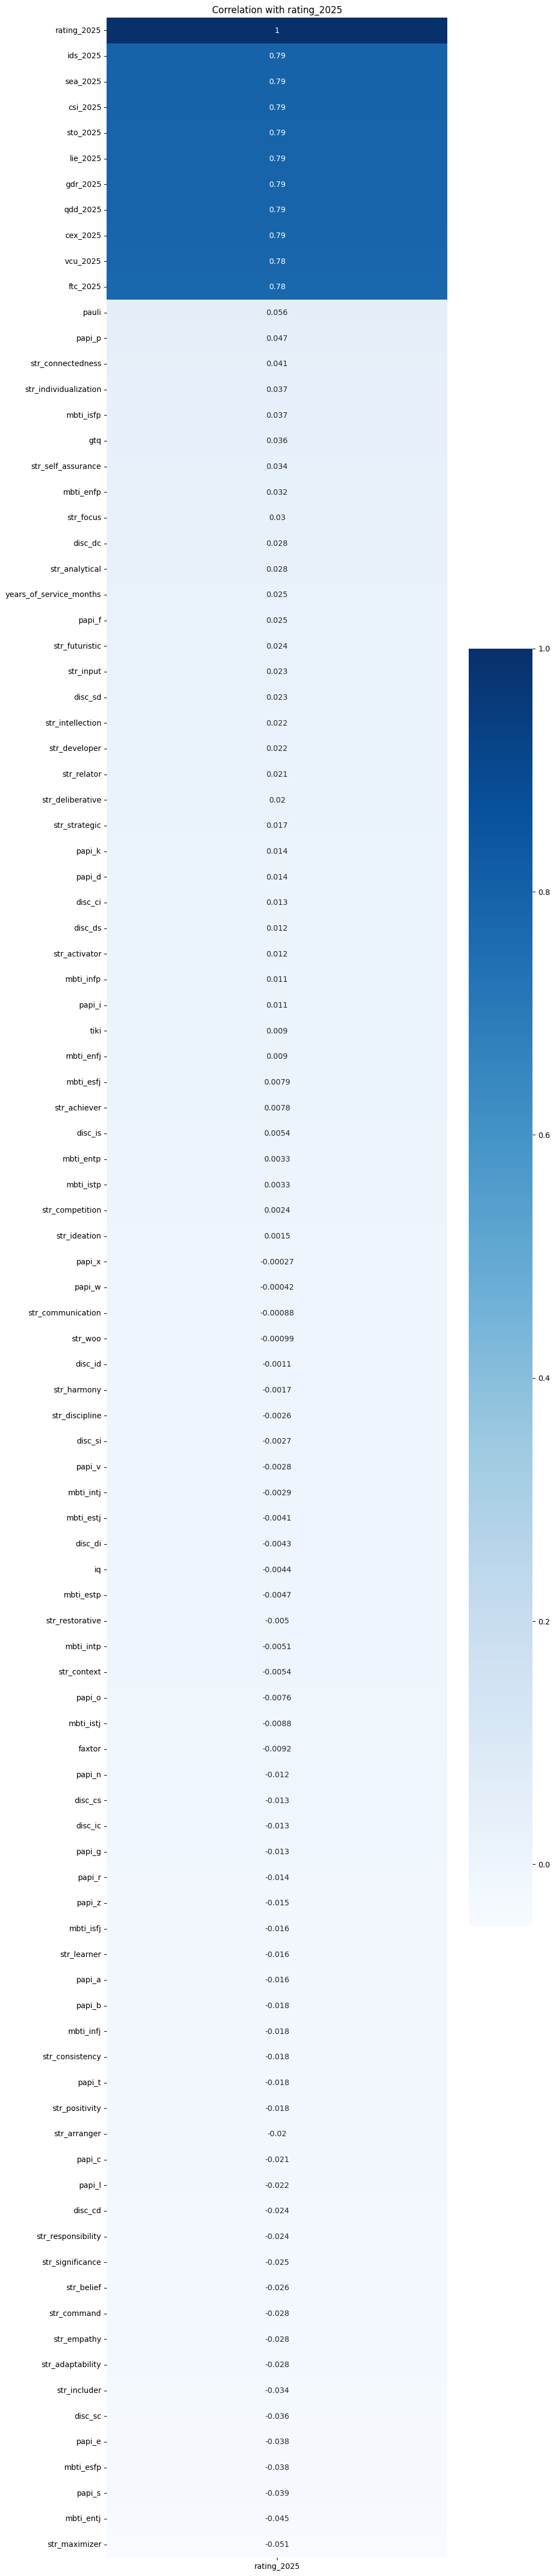

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Show correlation between the features and the target
target_col = "rating_2025"

df_corr = df_master[all_features].select_dtypes(include=['float64','int64'])

plt.figure(figsize=(10, 60))
sns.heatmap(
    df_corr.corr()[[target_col]].sort_values(by=target_col, ascending=False),
    annot=True,
    cmap="Blues"
)
plt.title(f"Correlation with {target_col}")
plt.show()

## Top correlated feature with performance (>=0.03):

In [44]:
corr_series = df_corr.corr()[target_col].drop(target_col)
corr_selected = corr_series[corr_series >= 0.03]
corr_selected

,rating_2025
cex_2025,0.785276
csi_2025,0.791953
ftc_2025,0.777375
gdr_2025,0.789908
ids_2025,0.793682
lie_2025,0.790352
qdd_2025,0.787299
sea_2025,0.793598
sto_2025,0.790454
vcu_2025,0.779426


1. Competencies 2025:
    - IDS: 0.79
    - SEA: 0.79
    - CSI: 0.79
    - STO: 0.79
    - LIE: 0.79
    - GDR: 0.79
    - QDD: 0.79
    - CEX: 0.79
    - VCU: 0.78
    - FTC: 0.78

2. Psychometric:
    - Pauli: 0.056
    - MBTI
      - mbti_istp: 0.037
      - mbti_enfp: 0.032
    - gtq: 0.036

3. PAPI:
    - papi_p: 0.047

4. Strengths:
    - str_connectedness: 0.041
    - str_individualization: 0.037
    - str_self_assurance: 0.034

## Calculate weight using |corr_i| / Σ|corr_all|:

In [32]:
weights = corr_selected / corr_selected.sum()

weights_df = pd.DataFrame({
    "correlation": corr_selected,
    "weight": weights
}).sort_values("weight", ascending=False)

weights_df

,correlation,weight
ids_2025,0.793682,0.096808
sea_2025,0.793598,0.096798
csi_2025,0.791953,0.096597
sto_2025,0.790454,0.096414
lie_2025,0.790352,0.096402
gdr_2025,0.789908,0.096348
qdd_2025,0.787299,0.096029
cex_2025,0.785276,0.095782
vcu_2025,0.779426,0.095069
ftc_2025,0.777375,0.094819


## FINAL SUCCESS SCORE FORMULA  

Succes Score Formula =
Σ(weight_i × feature_i_normalized)  

Success Score Formula=  
0.096808 × IDS_2025_norm +
0.096798 × SEA_2025_norm +
0.096597 × CSI_2025_norm +
0.096414 × STO_2025_norm +
0.096402 × LIE_2025_norm +
0.096348 × GDR_2025_norm +
0.096029 × QDD_2025_norm +
0.095782 × CEX_2025_norm +
0.095069 × VCU_2025_norm +
0.094819 × FTC_2025_norm +
0.006845 × pauli_norm +
0.004400 × gtq_norm +
0.004525 × mbti_isfp_norm +
0.003863 × mbti_enfp_norm +
0.005685 × papi_p_norm +
0.004967 × str_connectedness_norm +
0.004526 × str_individualization_norm +
0.004123 × str_self_assurance_norm

In [33]:
from sklearn.preprocessing import StandardScaler

features_for_formula = weights_df.index.tolist()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_master[features_for_formula])

df_scaled = pd.DataFrame(X_scaled, columns=features_for_formula)
df_scaled["employee_id"] = df_master["employee_id"]

In [40]:
df_master["success_score"] = 0

for feature, weight in weights_df["weight"].items():
    df_master["success_score"] += df_scaled[feature] * weight

df_master.sort_values("success_score", ascending=False)

,employee_id,fullname,nip,company_id,area_id,position_id,department_id,division_id,directorate_id,grade_id,...,sto_2023,sto_2024,sto_2025,vcu_2021,vcu_2022,vcu_2023,vcu_2024,vcu_2025,is_top,success_score
1787,EMP101787,Zaki Subekti,691605,1,3,3,5,4,3,2,...,2.0,3.0,5.0,2.0,1.0,2.0,2.0,5.0,1,1.678136
462,EMP100462,Lestari Anggara,802474,4,3,5,6,2,1,1,...,3.0,3.0,5.0,3.0,5.0,3.0,2.0,5.0,1,1.670034
1167,EMP101167,Rama Utami,659007,4,2,3,6,4,2,2,...,3.0,3.0,5.0,4.0,4.0,3.0,2.0,5.0,1,1.666520
313,EMP100313,Budi Qolbi Hidayat,928862,1,3,2,3,4,3,1,...,4.0,5.0,5.0,4.0,3.0,5.0,4.0,5.0,1,1.663498
1550,EMP101550,Ayunda Firmansyah,187663,4,2,3,5,5,2,3,...,1.0,3.0,5.0,4.0,4.0,1.0,3.0,5.0,1,1.650372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1284,EMP101284,Nadia Mahardika Purnama,225814,1,3,4,2,4,3,1,...,4.0,2.0,1.0,2.0,3.0,3.0,3.0,1.0,0,-1.782665
345,EMP100345,Arif Jatmiko Wibowo,904691,3,1,6,6,1,3,2,...,3.0,3.0,1.0,3.0,3.0,3.0,3.0,1.0,0,-1.786529
115,EMP100115,Satya Yudhistira Lukman,804211,2,1,1,2,4,2,1,...,4.0,2.0,1.0,2.0,5.0,4.0,2.0,1.0,0,-1.787573
191,EMP100191,Cahyo Wijaya,731090,3,1,5,1,4,1,1,...,2.0,3.0,1.0,3.0,3.0,2.0,4.0,1.0,0,-1.787809
